In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from models import VarMiON, FullyConnectedNN, Branch_Net
from torch.utils.data import DataLoader
from datasets import SHDataset

In [2]:
# Set seed
manualSeed = 345
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
np.random.seed(manualSeed)

#Set device
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [3]:
# Netword parameters
'''
neurons -- neurons in the Trunk Net
num_layer -- number of layers in the Trunk
input_dim -- input dimension of Trunk
output_dim -- output dimension of Trunk and Branch Nets
'''
neurons, num_layer, input_dim, output_dim = 100, 3, 2, 64
batch_size = 64

In [4]:
theta_file = "F:\Code\Steady Heat Conduction\sample_theta_32.npy"
f_file = "F:\Code\Steady Heat Conduction\sample_f_32.npy"
t_file = "F:\Code\Steady Heat Conduction\Data\T_48_11_11.npy"
train_dataset = SHDataset(theta_file, f_file, t_file, "train")
test_dataset = SHDataset(theta_file, f_file, t_file, "test")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

## Training

In [5]:
lr = 1e-3
loss_fn = nn.L1Loss(reduction="mean")
num_epoches = 1000
train_loss = []
test_loss = []

In [6]:
trunk_net = FullyConnectedNN(neurons, num_layer, input_dim, output_dim).to(device)
branch_net = Branch_Net().to(device)
varmion = VarMiON(trunk_net, branch_net)

# Optimizer
params = list(branch_net.parameters()) + list(trunk_net.parameters())
optimizer = optim.Adam(params, lr=lr)


In [7]:
print(f"Train have {train_dataset[0][0][-1].shape[0]} evaluation points")

coordinates_test = test_dataset.get_test_coordinates().to(device)
print(f"Test have {coordinates_test.shape[0]} evaluation points")

Train have 224 evaluation points
Test have 2401 evaluation points


In [8]:
for epoch in tqdm((range(num_epoches))):
    epoch_loss = 0

    for (theta, f, coordinates), labels in train_loader:
        
        theta, f, coordinates, labels = theta.to(device), f.to(device), coordinates.to(device), labels.to(device)

        pred = varmion(theta, f, coordinates)
        loss = loss_fn(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss.append(epoch_loss)

train_hist = np.array(train_loss) / len(train_loader)
    

100%|██████████| 1000/1000 [11:23<00:00,  1.46it/s]


Text(0.5, 1.0, 'Loss Curve of VarMiON')

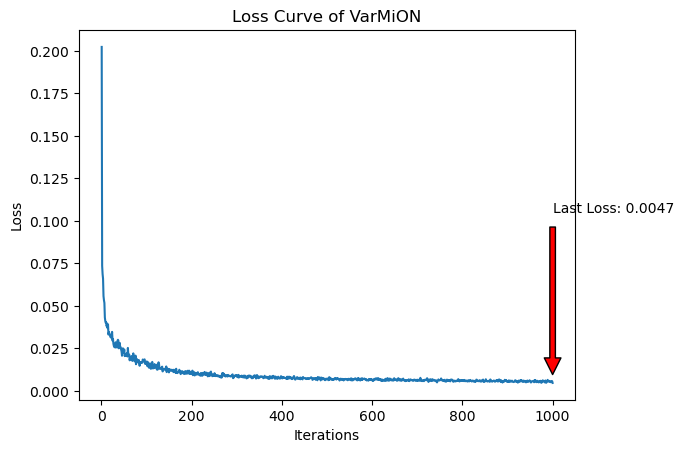

In [9]:
epoch_index = np.arange(num_epoches) + 1

plt.plot(epoch_index,train_hist)
# annotate the last loss
plt.annotate(f'Last Loss: {train_hist[-1]:.4f}',   
             xy=(epoch_index[-1], train_hist[-1]),   
             xytext=(epoch_index[-1] + 0.1, train_hist[-1] + 0.1),  # position of text 
             arrowprops=dict(facecolor='r', shrink=0.05))  # arrow style 
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve of VarMiON")

## Testing

In [10]:
with torch.no_grad():
    for (theta, f), labels in test_loader:
        theta, f, labels = theta.to(device), f.to(device), labels.to(device)
        pred = varmion(theta, f, coordinates_test)

        loss = loss_fn(pred, labels)

        test_loss.append(loss.item())
    
    test_hist = np.array(test_loss)

print(f"Accumulated loss in the testing datasets is {test_hist.sum():.4f}")

Accumulated loss in the testing datasets is 0.5262


## Visualization prediction and true displacement

In [11]:
pred_t = pred[1].detach().cpu().numpy()
label_t = labels[1].detach().cpu().numpy()

pred_t = pred_t.reshape(49, 49)
label_t = label_t.reshape(49, 49)

difference = np.abs(pred_t - label_t)

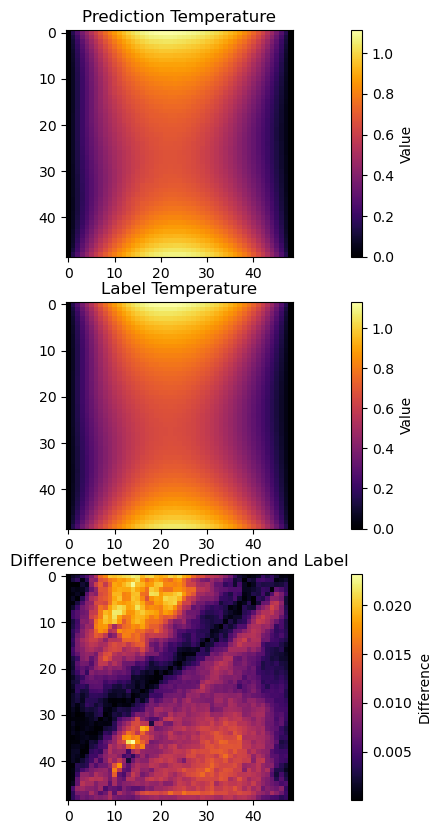

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

im1 = ax[0].imshow(pred_t, cmap='inferno')
fig.colorbar(im1, label="Value")
ax[0].set_title("Prediction Temperature")

im2 = ax[1].imshow(label_t, cmap='inferno')
fig.colorbar(im2, label="Value")
ax[1].set_title("Label Temperature")


im3 = ax[2].imshow(difference, cmap='inferno')
ax[2].set_title("Difference between Prediction and Label")
fig.colorbar(im3, label="Difference")